### Creating Maps with Cartographic Elements

This notebook shows how to use the [EOMaps](https://eomaps.readthedocs.io/en/latest/index.html) to crate maps with cartographic elements such as north arrow, scalebar and gridlines.

#### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install eomaps mapclassify

In [9]:
from eomaps import Maps
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)

In [5]:
shapefile_name = 'tl_2019_06_tract'
shapefile_exts = ['.shp', '.shx', '.dbf', '.prj']
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/census/'

for ext in shapefile_exts:
  url = data_url + shapefile_name + ext
  download(url)

csv_name = 'ACSST5Y2019.S0101_data.csv'
download(data_url + csv_name)


Downloaded data/tl_2019_06_tract.shp
Downloaded data/tl_2019_06_tract.shx
Downloaded data/tl_2019_06_tract.dbf
Downloaded data/tl_2019_06_tract.prj
Downloaded data/ACSST5Y2019.S0101_data.csv


#### Data Pre-Processing

Read the data and perform a table join.

In [ ]:
shapefile_path = os.path.join(data_folder, shapefile_name + '.shp')
tracts = gpd.read_file(shapefile_path)
csv_path = os.path.join(data_folder, csv_name)
table = pd.read_csv(csv_path, skiprows=[1])
filtered = table[['GEO_ID','NAME', 'S0101_C01_001E']]
filtered = filtered.rename(columns = {'S0101_C01_001E': 'Population', 'GEO_ID': 'GEOID'})
filtered['GEOID'] = filtered.GEOID.str[-11:]
gdf = tracts.merge(filtered, on='GEOID')
gdf['density'] = 1e6*gdf['Population']/gdf['ALAND']
gdf

#### Create a Map using EOMaps

Initialize a map with a CRS.

Referemce: [`eomaps.Maps()`](https://eomaps.readthedocs.io/en/latest/generated/eomaps.eomaps.Maps.html#eomaps.eomaps.Maps)

In [200]:
m = Maps(crs=Maps.CRS.Orthographic(-120, 35), figsize=(7, 7))

Set the map extent.

In [201]:
xmin, ymin, xmax, ymax = gdf.total_bounds
buffer = 0.1
m.set_extent([xmin-buffer, xmax+buffer, ymin-buffer, ymax+buffer])

Add the gridlines.

Reference: [`eomaps.Maps.add_gridlines()`](https://eomaps.readthedocs.io/en/latest/generated/eomaps.eomaps.Maps.add_gridlines.html)


In [202]:
g = m.add_gridlines(1, lw=0.25, alpha=0.5, zorder=0)
gl = g.add_labels(fontsize=10, every = 2)

Add North Arrow.

Reference: [`eomaps.Maps.add_compass()`](https://eomaps.readthedocs.io/en/latest/generated/eomaps.eomaps.Maps.add_compass.html#eomaps.eomaps.Maps.add_compass)

In [203]:
c = m.add_compass(style='compass', pos=(0.85, 0.9))

Add scalebar.

Reference: [`eomaps.Maps.add_scalebar()`](https://eomaps.readthedocs.io/en/latest/generated/eomaps.eomaps.Maps.add_scalebar.html)

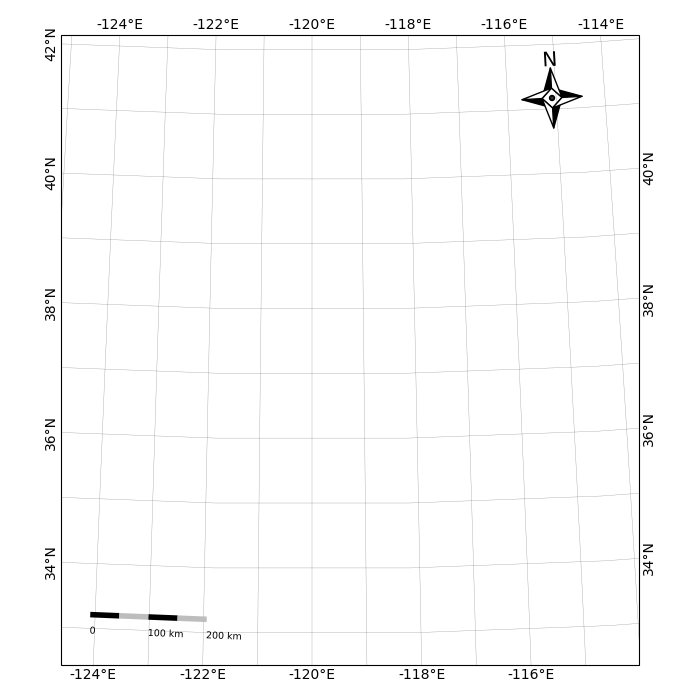

In [204]:
s = m.add_scalebar(
    n=4,
    scale=50000,
    auto_position=(0.05,0.08),
    preset='bw',
    rotation=90,
    label_props={'rotation':90, 'offset':1.5, 'family':'Helvetica', 'weight':0.5},
    scale_props={'colors': ('k','#bdbdbd','k','#bdbdbd','k')},
    line_props={'lw':0, 'ls': 'solid'}
)
m.show()

Plot the GeoDataFrame.

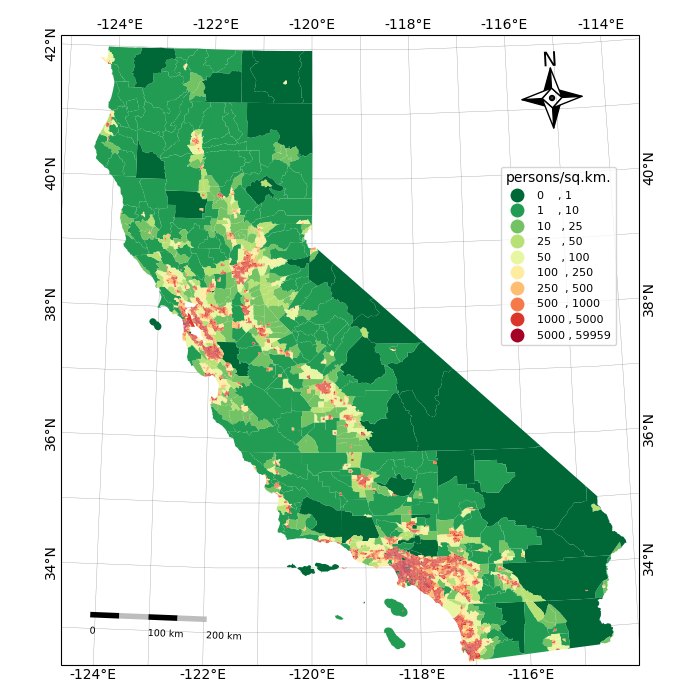

<Figure size 640x480 with 0 Axes>

In [205]:
legend_kwds= {
  'loc': 'upper right',
  'bbox_to_anchor': (0.97, 0.80),
  'fmt': '{:<5.0f}',
  'frameon': True,
  'fontsize': 8,
  'title': 'persons/sq.km.'
}
classification_kwds={
  'bins':[1,10,25,50,100, 250, 500, 1000, 5000]
}

m.add_gdf(gdf, column='density', cmap='RdYlGn_r', scheme='User_Defined',
          classification_kwds=classification_kwds,
          legend=True, legend_kwds=legend_kwds)
m.show()